**Part 3 ‐ Predictive modeling**

In [47]:
import json
import pandas as pd
import datetime as datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

In [2]:
ult = pd.read_json('...ultimate_data_challenge.json')

In [3]:
ult.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


**Data Cleaning Procedures**

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64


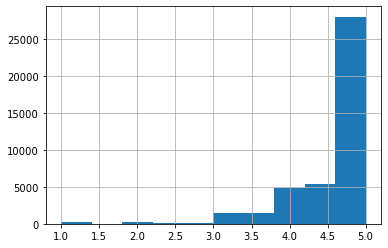

In [5]:
#Imputing missing data
#finding how the distribution looks like for features with missing values so that we can decide on how to impute them
# since it has a skewed distribution, it's better to impute with median than with mean values
ult['avg_rating_of_driver'].hist()
print(ult['avg_rating_of_driver'].describe())

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64


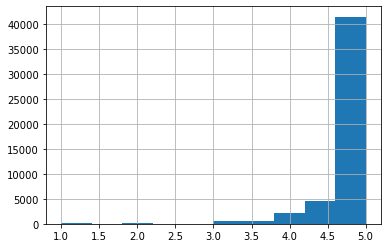

In [6]:
ult['avg_rating_by_driver'].hist()
print(ult['avg_rating_by_driver'].describe())

In [7]:
# Imputing
ult['avg_rating_by_driver']= ult['avg_rating_by_driver'].fillna(value=ult['avg_rating_by_driver'].median())
ult['avg_rating_of_driver']= ult['avg_rating_of_driver'].fillna(value=ult['avg_rating_of_driver'].median())

In [8]:
ult['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [9]:
#Almost 70% of users have iPhone, so the missing values could be imputed with iPhone
ult['phone']= ult['phone'].fillna(value='iPhone')

In [10]:
ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


**Fraction of Users that were Retained**

Since the date on which the data was pulled is not given, I assume the latest date of 'last_trip_date' as the date the data was pulled and if any user made a trip within the preceding 30 days then that user will be assumed as 'retained user'

In [11]:
# changing dates to datetime object
ult['signup_date'] = pd.to_datetime(ult['signup_date'])
ult['last_trip_date'] = pd.to_datetime(ult['last_trip_date'])

ult['last_trip_date'].dtype

ult['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [12]:
#Finding fraction of retained users
ret_users = []
for i in ult['last_trip_date']:
    if str(i) > '2014-06-01 00:00:00':
        ret_users.append(1)
    else:
        ret_users.append(0)

In [13]:
ult['ret_users'] = ret_users

In [14]:
ult['ret_users'].value_counts()

0    31690
1    18310
Name: ret_users, dtype: int64

In [15]:
print('retained_user % is {0:.2f}'.format(ult['ret_users'].value_counts()[1]/(ult['ret_users'].value_counts()[0] + ult['ret_users'].value_counts()[1])*100))

retained_user % is 36.62


**Building Predictive Model**

**Assumptions regarding 6 months cohorts**

One of the assumption taken here is that if the users have signed up in Jan and if their last trip is in June, they are active for 6 months; day of the month was not taken into considertation, for instance, if a user signed up on Jan.31st and had the last trip on June 1st, it will still be counted as 6 months active. dt.month = 6, means it's June.


In [16]:
ult['last_trip_month'] = ult['last_trip_date'].dt.month

In [17]:
ult.loc[(ult['last_trip_month'] >= 6), 'retained_user'] = 1
ult.loc[(ult['last_trip_month'] < 6), 'retained_user'] = 0

In [18]:
ult['retained_user'].value_counts()

0.0    31196
1.0    18804
Name: retained_user, dtype: int64

In [19]:
#% of retained users according to this assumption
print('retained user {0:.2f}'.format(ult['retained_user'].value_counts()[1]/((ult['retained_user'].value_counts()[1])+ult['retained_user'].value_counts()[0])*100))

retained user 37.61


**2. Predicting if the customer will be retained for 6 months or not**

**Exploratory Analysis on Features**

Categorical Features

In [20]:
ult['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

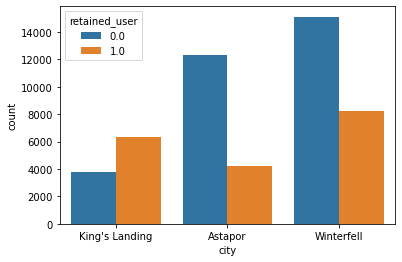

In [21]:
sns.countplot(x='city', hue='retained_user', data=ult)
plt.show()

from king's landing the retained users are higher than that of non-retained. In winterfell the % of retained_users are higher than that of Astapor city.

False    31146
True     18854
Name: ultimate_black_user, dtype: int64


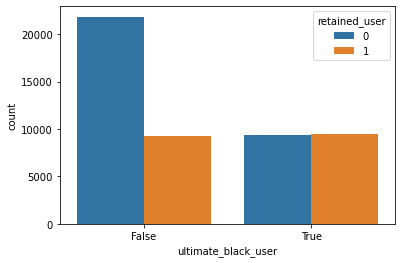

In [64]:
# Ultimate black user
print(ult['ultimate_black_user'].value_counts())
sns.countplot(x='ultimate_black_user', hue='retained_user', data=ult)
plt.show()

iPhone     34978
Android    15022
Name: phone, dtype: int64


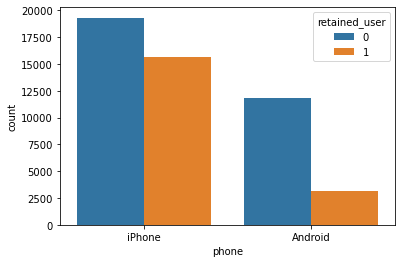

In [94]:
# Phone
print(ult['phone'].value_counts())
sns.countplot(x='phone', hue='retained_user', data=ult)
plt.show()

Around 50% of ultimate black users are retained and only around 25% of non-black_users are retained. Being an ultimate black user increases the likelihood of retaining.

**Numeric Features and how they are related to retained_user**


In [ ]:
we examine how the retained % (retainer/total customers) at each level of numeric variable.

In [22]:
#Writing a function for it.
def numvarplot(x,y):
    df_trips = ult.groupby(x).agg({y: ['sum', 'count']})
    # multiple levaes of columns were created, so first level was dropped
    df_trips.columns = df_trips.columns.droplevel()

    #calculating %retained
    perc_ret = (df_trips['sum']/df_trips['count'])*100

    # assigning trips as a column.
    df_trips['% retained'] = perc_ret

    df_trips.columns

    plt.figure(figsize=(18,8))
    sns.barplot(y='% retained', x=df_trips.index, data=df_trips)
    plt.show()

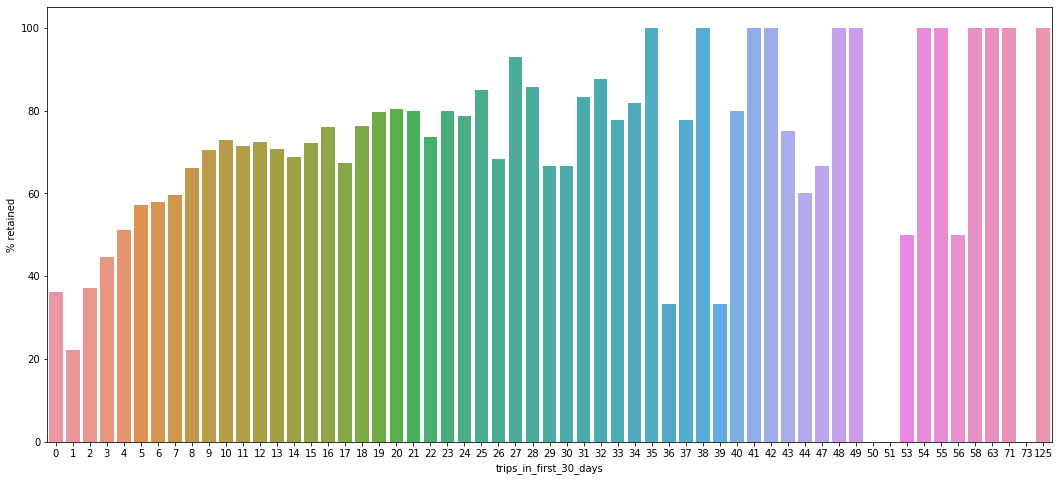

In [23]:
numvarplot('trips_in_first_30_days','retained_user')

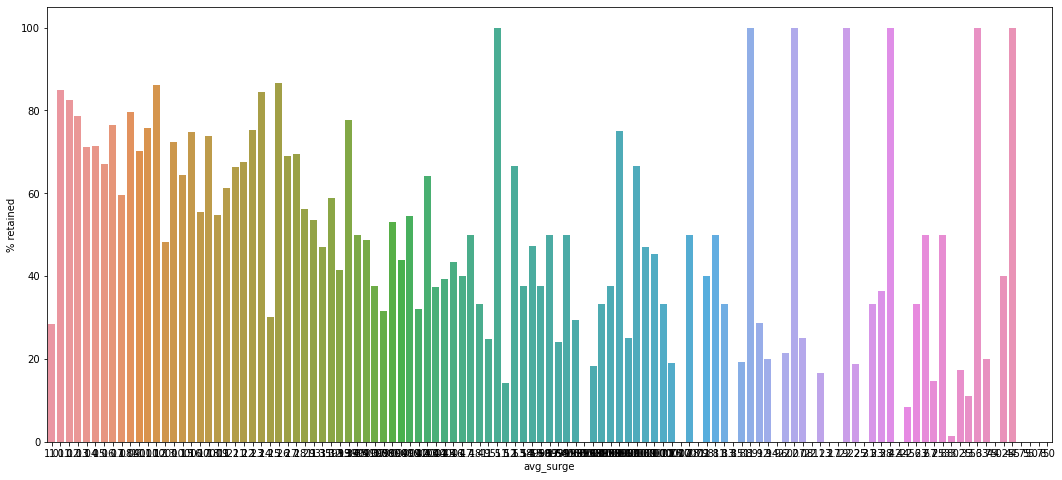

In [88]:
numvarplot('avg_surge','retained_user')

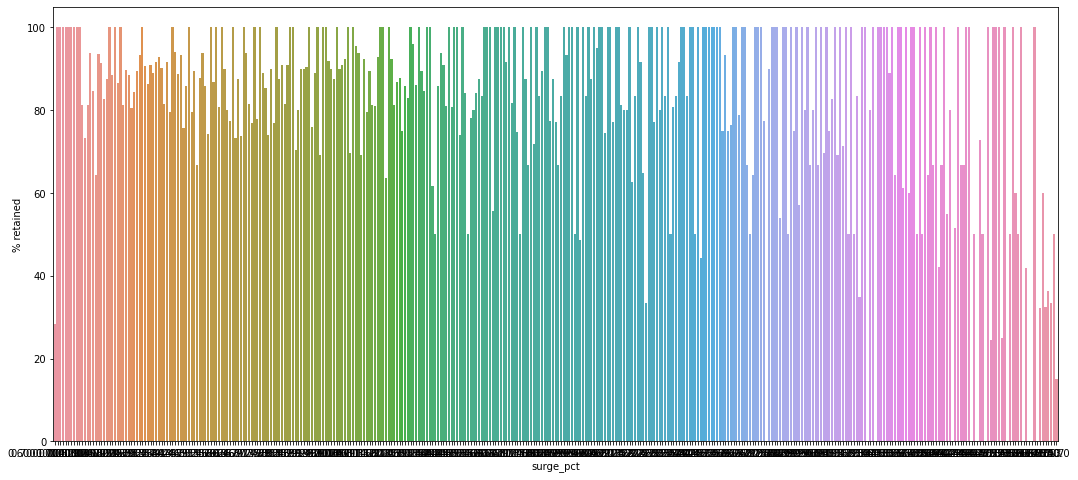

In [89]:
numvarplot('surge_pct','retained_user')

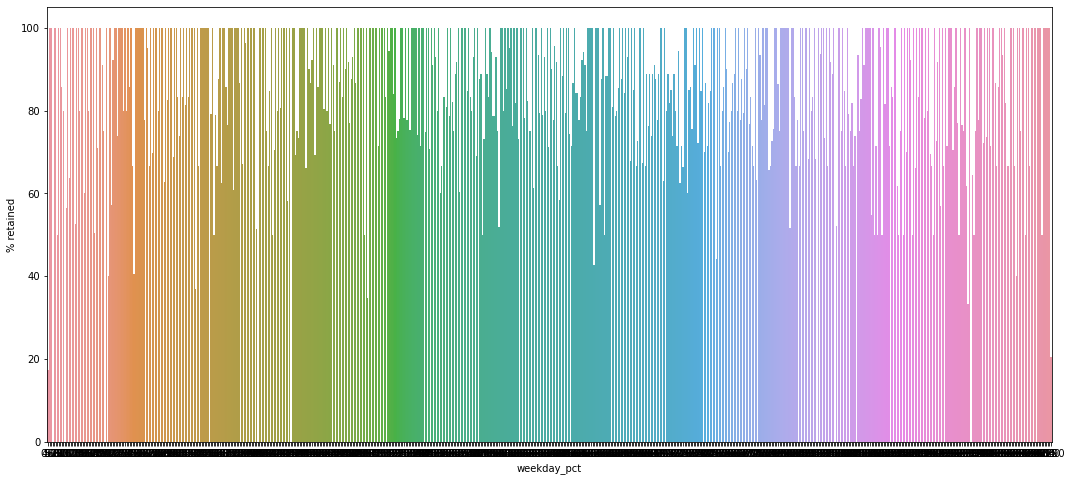

In [90]:
numvarplot('weekday_pct','retained_user')

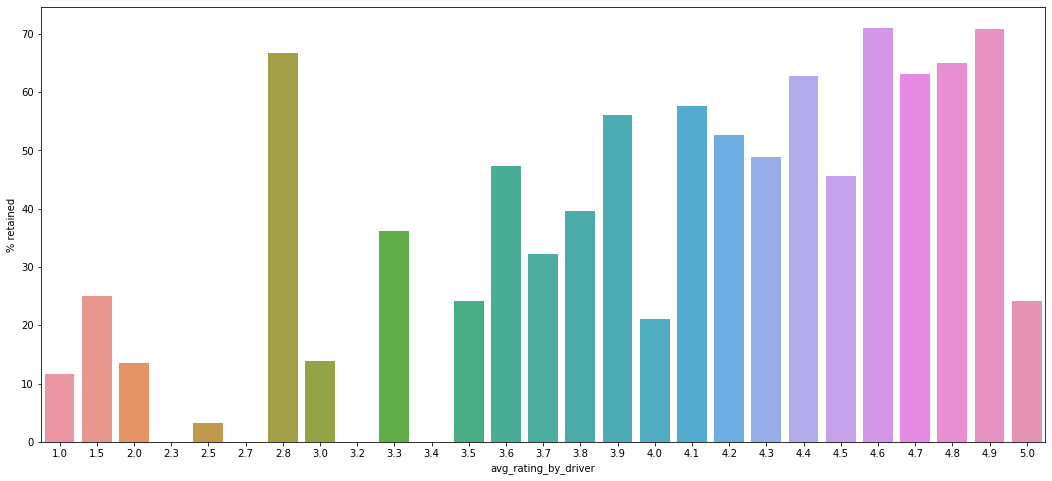

In [92]:
numvarplot('avg_rating_by_driver','retained_user')

Of the numeric variables, retained % increases only with trips_in_first_30_days, avg_rating_by_driver. With avg_surge the retained % decreases to some extent.

In [24]:
# renaming one of the attribute in city
ult['city'] = ult['city'].str.replace("King's Landing", "King_Landing")
ult['city'].value_counts()

Winterfell      23336
Astapor         16534
King_Landing    10130
Name: city, dtype: int64

In [50]:
#Creating dummies for city and ultimate black users
ult1 = pd.get_dummies(ult, columns=['city', 'ultimate_black_user', 'phone'])
ult1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   trips_in_first_30_days     50000 non-null  int64         
 1   signup_date                50000 non-null  datetime64[ns]
 2   avg_rating_of_driver       50000 non-null  float64       
 3   avg_surge                  50000 non-null  float64       
 4   last_trip_date             50000 non-null  datetime64[ns]
 5   surge_pct                  50000 non-null  float64       
 6   weekday_pct                50000 non-null  float64       
 7   avg_dist                   50000 non-null  float64       
 8   avg_rating_by_driver       50000 non-null  float64       
 9   ret_users                  50000 non-null  int64         
 10  last_trip_month            50000 non-null  int64         
 11  retained_user              50000 non-null  float64       
 12  city

In [51]:
ult1['city_King_Landing']=ult1['city_King_Landing'].astype(int)                  
           
ult1['city_Winterfell']=ult1['city_Winterfell'] .astype(int)             
        
ult1['ultimate_black_user_True']=ult1['ultimate_black_user_True'].astype(int)      
             
ult1['phone_iPhone']=ult1['phone_iPhone'].astype(int)      
ult1['retained_user']=ult1['retained_user'].astype(int)  

**Preprocessing Steps**

In [52]:
ult1 = ult1.drop(columns = ['last_trip_date', 'last_trip_month','ret_users','signup_date','city_Astapor', 'ultimate_black_user_False', 'phone_Android'], axis=1)

In [53]:
X = ult1.drop(columns= 'retained_user', axis=1)
y = ult1['retained_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=19)

In [54]:
X_train.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_King_Landing,city_Winterfell,ultimate_black_user_True,phone_iPhone
42600,0,5.0,1.0,0.0,80.0,10.48,4.6,0,0,1,1
36209,0,5.0,1.0,0.0,100.0,15.54,5.0,0,1,0,0
24117,1,5.0,1.0,0.0,100.0,1.05,5.0,0,0,0,1
31683,0,5.0,1.0,0.0,100.0,8.97,3.0,0,0,0,1
23298,3,5.0,1.0,0.0,100.0,6.52,5.0,0,0,0,0


In [55]:
#Standardizing numeric features

#numeric features are in the index range 0 through 7

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train.iloc[:, 0:7] = scaler.fit_transform(X_train.iloc[:, 0:7])
X_test.iloc[:, 0:7] = scaler.transform(X_test.iloc[:, 0:7])

X_train.head()

X_test.head()

C:\Users\tnsub\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\tnsub\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_King_Landing,city_Winterfell,ultimate_black_user_True,phone_iPhone
49715,-0.336787,0.433813,-0.334274,-0.442379,-1.636999,2.668197,0.493992,0,1,1,1
12010,1.260604,-0.611050,-0.334274,-0.442379,-0.099379,-0.243403,-0.178956,0,1,0,1
19469,-0.603018,0.433813,-0.334274,-0.442379,-1.636999,-0.243403,-1.749170,0,1,0,1
6261,-0.603018,0.607957,-0.334274,-0.442379,-0.290572,0.527468,0.493992,1,0,0,1
5857,-0.070555,-0.959338,0.157832,0.278550,-0.481764,0.190646,-0.178956,0,0,0,1


In [56]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
y_pred_prob = lr.predict_proba(X_train)[:,1]
y_pred_prob1 = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

print('Logistic regression_train_accuracy is {0:.3f}'.format(accuracy_score(lr.predict(X_train), y_train)))
print('Logistic regression_test_accuracy is {0:.3f}'.format(accuracy_score(lr.predict(X_test), y_test)))
print('Logistic regression_train_auc is {0:.3f}'.format(auc(fpr, tpr)))
print('Logistic regression_test_auc is {0:.3f}'.format(auc(fpr1, tpr1)))

Logistic regression_train_accuracy is 0.719
Logistic regression_test_accuracy is 0.719
Logistic regression_train_auc is 0.761
Logistic regression_test_auc is 0.760


In [57]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, random_state=1, learning_rate=0.01, eval_metric='mlogloss')
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_train)[:,1]
y_pred_proba1 = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_proba1)

print('XGBoost train accuracy is {0:.3f}'.format(accuracy_score(model.predict(X_train), y_train)))
print('XGBoost test accuracy is {0:.3f}'.format(accuracy_score(model.predict(X_test), y_test)))
print('XGBoost train auc is {0:.3f}'.format(auc(fpr, tpr)))
print('XGBoost test auc is {0:.3f}'.format(auc(fpr1, tpr1)))

XGBoost train accuracy is 0.782
XGBoost test accuracy is 0.778
XGBoost train auc is 0.848
XGBoost test auc is 0.840


In [58]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6618 1205]
 [1574 3103]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      7823
           1       0.72      0.66      0.69      4677

    accuracy                           0.78     12500
   macro avg       0.76      0.75      0.76     12500
weighted avg       0.78      0.78      0.78     12500



In [59]:
max_depth = [3,4,5]
learning_rate = [0.01, 0.05, 0.10]
subsample = [0.8]
colsample_bytree = [0.5,0.75]
n_estimators = [100]
min_child_weight = [1,2]
param_grid = {
    "max_depth": max_depth,
    "learning_rate": learning_rate,
    "subsample": subsample,
    "colsample_bytree": colsample_bytree,
    "n_estimators": n_estimators,
    "min_child_weight" : min_child_weight
}

xgb_cl = XGBClassifier(use_label_encoder=False, random_state=1, eval_metric='mlogloss')

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=10, scoring="accuracy")

# Fit
grid_cv.fit(X_train, y_train)
grid_cv.best_params_

{'colsample_bytree': 0.75,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 2,
 'n_estimators': 100,
 'subsample': 0.8}

In [60]:
y_pred_proba = grid_cv.predict_proba(X_train)[:,1]
y_pred_proba1 = grid_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
fpr_xgb, tpr_xgb, thresholds1 = roc_curve(y_test, y_pred_proba1)
precision_xgb, recall_xgb, thresholds = precision_recall_curve(y_test, y_pred_proba1)

In [61]:
print('XGBoost gridsearcv train accuracy is {0:.3f}'.format(accuracy_score(grid_cv.predict(X_train), y_train)))
print('XGBoost gridsearcv test accuracy is {0:.3f}'.format(accuracy_score(grid_cv.predict(X_test), y_test)))
print('XGBoost gridsearcv train auc is {0:.3f}'.format(auc(fpr, tpr)))
print('XGBoost gridsearcv test auc is {0:.3f}'.format(auc(fpr_xgb, tpr_xgb)))

XGBoost gridsearcv train accuracy is 0.801
XGBoost gridsearcv test accuracy is 0.790
XGBoost gridsearcv train auc is 0.873
XGBoost gridsearcv test auc is 0.857


In [62]:
print(confusion_matrix(y_test, grid_cv.predict(X_test)))
print(classification_report(y_test, grid_cv.predict(X_test)))

[[6772 1051]
 [1569 3108]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      7823
           1       0.75      0.66      0.70      4677

    accuracy                           0.79     12500
   macro avg       0.78      0.77      0.77     12500
weighted avg       0.79      0.79      0.79     12500



In [64]:
# Using tuned parameters finally with the XG Boost model to get feature importances
xgb_t = XGBClassifier(use_label_encoder=False, colsample_bytree = 0.75, learning_rate = 0.1, max_depth = 5, 
                      min_child_weight = 2, n_estimators = 100, subsample = 0.8, random_state=1, eval_metric='mlogloss')
xgb_t_fit = xgb_t.fit(X_train, y_train)

In [65]:
xgb_t.feature_importances_

array([0.03964522, 0.02624048, 0.02654076, 0.10293648, 0.07599992,
       0.01628549, 0.2423975 , 0.19537203, 0.03200989, 0.07873995,
       0.1638322 ], dtype=float32)

In [66]:
#Getting Feature importances
F_imps = pd.concat([pd.DataFrame(X_test.columns,columns=['features']),pd.DataFrame(np.transpose(xgb_t.feature_importances_), columns=['Imps'])], axis = 1)
# Coefficients' values sorted in descending order by their absolute values.
F_imps.reindex(F_imps.Imps.abs().sort_values(ascending=False).index).head(20)

,features,Imps
6,avg_rating_by_driver,0.242398
7,city_King_Landing,0.195372
10,phone_iPhone,0.163832
3,surge_pct,0.102936
9,ultimate_black_user_True,0.078740
4,weekday_pct,0.076000
0,trips_in_first_30_days,0.039645
8,city_Winterfell,0.032010
2,avg_surge,0.026541
1,avg_rating_of_driver,0.026240


**Summary and Conculsion:**
    

In this study, different models were used to predict retained users; logistic regression, XG Boost and XG Boost with parameter tuning. The latter performed better with a test accuracy of 0.79 and AUC of 0.856. Some of the important features that helped in determining retained users were avg_rating_by_driver, city_King_Landing, phone_iPhone, surge_pct, and ultimate_black_user_True. 	
model helped predict 3081 retained users correctly out of 4677 (recall of 0.66). Also the model helped identifying 87% of users who quit before 6 months. 

3 important things need to considered in terms of retaining users for more than 6 months:
    1.rider's rating about their trips matters alot, while it's important to maintain a higher rating from riders, it's better 
      to do a qualitative study from dissatisfied customers about why they don't stay longer.
      their issues with the rides, and the reason for their low rating
    2. It seems like customers from King's Landing, stay longer than from other cities, need to investigate why others do not 
      stay longer.
    3.Also customers with iPhone stay longer, which implies that Andriod customers quit easily. There could be reasons like the 
      'ride app' may not be working properly in customers' with Andriod. This needs to be considered too.